In [1]:
# Download
from itertools import chain
from collections import defaultdict
from torch.utils.data import Subset
from torchvision import datasets


def subset_sampler(dataset, classes, max_len):
    target_idx = defaultdict(list)
    for idx, label in enumerate(dataset.train_labels):
        target_idx[int(label)].append(idx)

    indices = list(
        chain.from_iterable(
            [target_idx[idx][:max_len] for idx in range(len(classes))]
        )
    )
    return Subset(dataset, indices)


train_dataset = datasets.FashionMNIST(root="../datasets", download=True, train=True)
test_dataset = datasets.FashionMNIST(root="../datasets", download=True, train=False)

classes = train_dataset.classes
class_to_idx = train_dataset.class_to_idx

print(classes)
print(class_to_idx)

subset_train_dataset = subset_sampler(
    dataset=train_dataset, classes=train_dataset.classes, max_len=1000
)
subset_test_dataset = subset_sampler(
    dataset=test_dataset, classes=test_dataset.classes, max_len=100
)

print(f"Training Data Size : {len(subset_train_dataset)}")
print(f"Testing Data Size : {len(subset_test_dataset)}")
print(train_dataset[0])

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
{'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}


/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


Training Data Size : 10000
Testing Data Size : 1000
(<PIL.Image.Image image mode=L size=28x28 at 0x7AE49C8A76A0>, 9)


데이터 수와 레이블 확인

In [2]:
# data preprocessing
import torch
from torchvision import transforms
from transformers import AutoImageProcessor

# autoImageprocessor사용
image_processor = AutoImageProcessor.from_pretrained(
    pretrained_model_name_or_path="google/vit-base-patch16-224-in21k"
)

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize(
            size=(
                image_processor.size["height"],
                image_processor.size["width"]
            )
        ),
        transforms.Lambda(
            lambda x: torch.cat([x, x, x], 0)
        ),
        transforms.Normalize(
            mean=image_processor.image_mean,
            std=image_processor.image_std
        )
    ]
)

print(f"size : {image_processor.size}")
print(f"mean : {image_processor.image_mean}")
print(f"std : {image_processor.image_std}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


size : {'height': 224, 'width': 224}
mean : [0.5, 0.5, 0.5]
std : [0.5, 0.5, 0.5]


이미지를 224x224사이즈로 처리하고 평균과 표준편차를 정규화를 함.

In [3]:
# ViT Loader 적용
from torch.utils.data import DataLoader


def collator(data, transform):
    images, labels = zip(*data)
    pixel_values = torch.stack([transform(image) for image in images])
    labels = torch.tensor([label for label in labels])
    return {"pixel_values": pixel_values, "labels": labels}


train_dataloader = DataLoader(
    subset_train_dataset,
    batch_size=32,
    shuffle=True,
    collate_fn=lambda x: collator(x, transform),
    drop_last=True
)
valid_dataloader = DataLoader(
    subset_test_dataset,
    batch_size=4,
    shuffle=True,
    collate_fn=lambda x: collator(x, transform),
    drop_last=True
)

batch = next(iter(train_dataloader))
for key, value in batch.items():
    print(f"{key} : {value.shape}")

pixel_values : torch.Size([32, 3, 224, 224])
labels : torch.Size([32])


- pixel value는 batch size, channel, image H, W로 구성.
- label은 클래스 index

In [4]:
# pre-trained model from huggingface
from transformers import ViTForImageClassification


model = ViTForImageClassification.from_pretrained(
    pretrained_model_name_or_path="google/vit-base-patch16-224-in21k",
    num_labels=len(classes),
    id2label={idx: label for label, idx in class_to_idx.items()},
    label2id=class_to_idx,
    ignore_mismatched_sizes=True
)

print(model.classifier)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Linear(in_features=768, out_features=10, bias=True)


classifier의 출력 데이터 차원 크기를 10개로 반환한다.  

In [5]:
# patch embedding
print(model.vit.embeddings)

ViTEmbeddings(
  (patch_embeddings): ViTPatchEmbeddings(
    (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (dropout): Dropout(p=0.0, inplace=False)
)


In [6]:
batch = next(iter(train_dataloader))
print("image shape :", batch["pixel_values"].shape)
print("patch embeddings shape :",
    model.vit.embeddings.patch_embeddings(batch["pixel_values"]).shape #patch embedding 처리 방식을 확인하기 위함.
)
print("[CLS] + patch embeddings shape :",
    model.vit.embeddings(batch["pixel_values"]).shape
)


image shape : torch.Size([32, 3, 224, 224])
patch embeddings shape : torch.Size([32, 196, 768])
[CLS] + patch embeddings shape : torch.Size([32, 197, 768])


cls 토큰을 패치 앞에 붙였다.  
입력 데이터를 일정한 크기의 패치로 분할한 후 패치마다 특성을 추출.  
이를 위해 patch_embedding 추가

In [7]:
# hyperparameter setup
!pip install transformers[torch]
!pip install accelerate -U

!pip install transformers[torch] --upgrade
!pip install accelerate --upgrade


import transformers
import accelerate
# print(transformers.__version__)
# print(accelerate.__version__)

from transformers import TrainingArguments #TrainingArguments는 모델 학습에 필요한 인자들을 저장하고 관리할 수 있게 함.

args = TrainingArguments(
    output_dir="../models/ViT-FashionMNIST",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.001,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_dir="logs",
    logging_steps=125,
    remove_unused_columns=False,
    seed=7
)



/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


모델의 성능을 평가하기 위한 성능 평가 지표로 Macro Average F1-score

In [8]:
!pip install evaluate
import evaluate
import numpy as np


def compute_metrics(eval_pred):
    metric = evaluate.load("f1")
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    macro_f1 = metric.compute(
        predictions=predictions, references=labels, average="macro"
    )
    return macro_f1

## Model training

In [9]:
#import for ViT

import torch
import evaluate
import numpy as np
from itertools import chain
from collections import defaultdict
from torch.utils.data import Subset
from torchvision import datasets
from torchvision import transforms
from transformers import AutoImageProcessor
from transformers import ViTForImageClassification
from transformers import TrainingArguments, Trainer

In [10]:
# 주어진 데이터셋에서 각 클래스별로 최대 max_len 개수의 샘플을 선택하여 부분 집합을 생성
def subset_sampler(dataset, classes, max_len):
    target_idx = defaultdict(list)
    for idx, label in enumerate(dataset.train_labels): #클래스 별 인덱스 수집
        target_idx[int(label)].append(idx)

    indices = list( #최대 샘플 개수로 인덱스 제한
        chain.from_iterable(
            [target_idx[idx][:max_len] for idx in range(len(classes))]
        )
    )
    return Subset(dataset, indices)
# 특정 클래스의 데이터 샘플을 제한하여 모델이 특정 클래스에 과적합하지 않도록 하기 위함.

In [11]:
def model_init(classes, class_to_idx):
    model = ViTForImageClassification.from_pretrained(
        pretrained_model_name_or_path="google/vit-base-patch16-224-in21k",
        num_labels=len(classes),
        id2label={idx: label for label, idx in class_to_idx.items()},
        label2id=class_to_idx,
    )
    return model

In [12]:
# 주어진 데이터 샘플들을 변환하고 배치로 결합하여 반환하는 collate function, 데이터 로더에서 사용하여 모델 학습을 위해 배치 단위로 데이터를 전처리하고 결합하는 역할
def collator(data, transform):
    images, labels = zip(*data)
    pixel_values = torch.stack([transform(image) for image in images])
    labels = torch.tensor([label for label in labels])
    return {"pixel_values": pixel_values, "labels": labels}

In [13]:
# metric set
def compute_metrics(eval_pred):
    metric = evaluate.load("f1")
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    macro_f1 = metric.compute(
        predictions=predictions, references=labels, average="macro"
    )
    return macro_f1

In [14]:
# data preprocessing
train_dataset = datasets.FashionMNIST(root="../datasets", download=True, train=True)
test_dataset = datasets.FashionMNIST(root="../datasets", download=True, train=False)

classes = train_dataset.classes
class_to_idx = train_dataset.class_to_idx

subset_train_dataset = subset_sampler(
    dataset=train_dataset, classes=train_dataset.classes, max_len=1000
)
subset_test_dataset = subset_sampler(
    dataset=test_dataset, classes=test_dataset.classes, max_len=100
)

image_processor = AutoImageProcessor.from_pretrained(
    pretrained_model_name_or_path="google/vit-base-patch16-224-in21k"
)

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize(
            size=(
                image_processor.size["height"],
                image_processor.size["width"]
            )
        ),
        transforms.Lambda(
            lambda x: torch.cat([x, x, x], 0)
        ),
        transforms.Normalize(
            mean=image_processor.image_mean,
            std=image_processor.image_std
        )
    ]
)

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


In [15]:
# train argument set up
args = TrainingArguments(
    output_dir="../models/ViT-FashionMNIST",
    save_strategy="epoch",
    evaluation_strategy="epoch", #  Use `eval_strategy` instead
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.001,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_dir="logs",
    logging_steps=125,
    remove_unused_columns=False,
    seed=7
)

# trainer set up&go
trainer = Trainer(
    model_init=lambda x: model_init(classes, class_to_idx),
    args=args,
    train_dataset=subset_train_dataset,
    eval_dataset=subset_test_dataset,
    data_collator=lambda x: collator(x, transform),
    compute_metrics=compute_metrics,
    tokenizer=image_processor,
)
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,0.699100,0.631618,0.884004
2,0.476200,0.472858,0.912262


Epoch,Training Loss,Validation Loss,F1
1,0.699100,0.631618,0.884004
2,0.476200,0.472858,0.912262
3,0.414700,0.425346,0.919208


TrainOutput(global_step=1875, training_loss=0.6954773152669271, metrics={'train_runtime': 15837.2075, 'train_samples_per_second': 1.894, 'train_steps_per_second': 0.118, 'total_flos': 2.32492637712384e+18, 'train_loss': 0.6954773152669271, 'epoch': 3.0})

PredictionOutput(predictions=array([[ 3.0752287 , -0.6367264 , -0.3320943 , ..., -0.57851845,
        -0.35522476, -0.6043052 ],
       [ 2.0724614 , -0.7122487 , -0.23807092, ..., -0.80780977,
        -0.81954616, -1.0080667 ],
       [ 2.971065  , -0.5970683 , -0.15059322, ..., -0.53042465,
        -0.38883355, -0.57946295],
       ...,
       [-0.61569   , -0.5913869 , -0.5417704 , ...,  0.6028994 ,
         0.3651839 ,  2.9985378 ],
       [-0.56245446, -0.3819499 , -0.29692903, ...,  0.11526013,
        -0.29454055,  3.4022214 ],
       [-0.5415687 , -0.32886818, -0.29273948, ..., -0.2833264 ,
        -0.15187353,  3.4143167 ]], dtype=float32), label_ids=array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

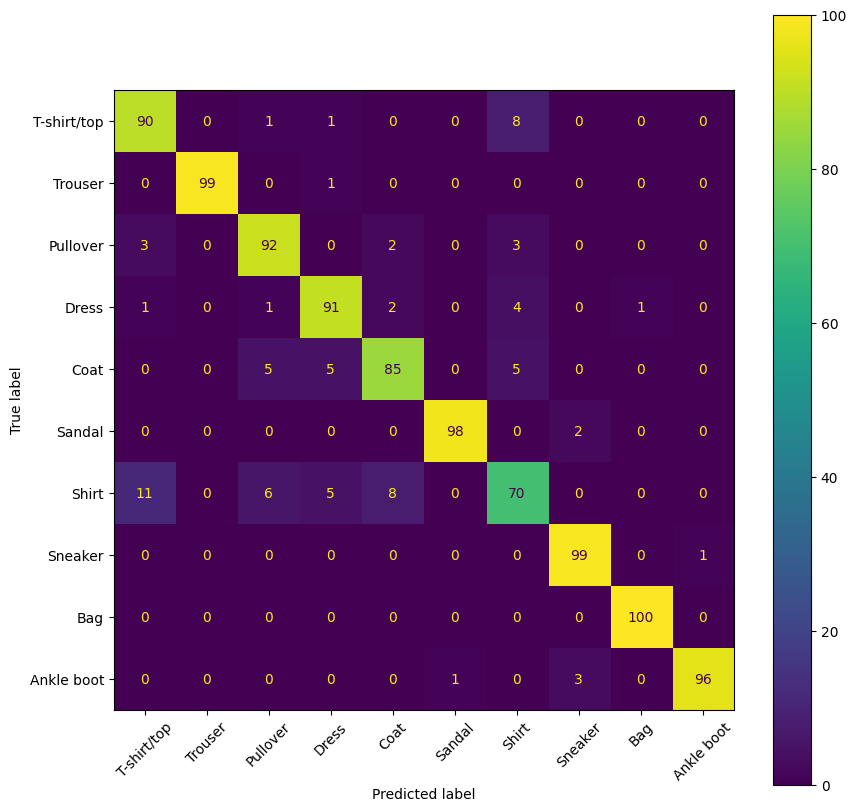

In [16]:
#Confusion Matrix를 활용하여 모델의 성능평가 확인
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


outputs = trainer.predict(subset_test_dataset)
print(outputs)

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = list(classes)
matrix = confusion_matrix(y_true, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=labels)
_, ax = plt.subplots(figsize=(10, 10))
display.plot(xticks_rotation=45, ax=ax)
plt.show()



특징:    
- 패치 분할: 입력 이미지를 고정된 크기의 패치로 분할. 각 패치는 일종의 "토큰"으로 처리
- 토큰 임베딩: 패치들을 선형 임베딩하여 위치 임베딩(position embedding)과 결합
- Transformer 인코더: Transformer 인코더 블록을 통해 각 패치의 임베딩을 처리하여 전역적인 문맥 정보를 학습
- 간단한 구조: CNN이 아닌 Transformer만을 사용하여 이미지 분류를 수행

장점:

전역적인 문맥 정보를 잘 학습할 수 있음.
매우 단순한 구조로, 다양한 데이터셋에 쉽게 적용 가능

단점:

많은 데이터와 계산 자원이 필요
로컬 정보(예: 텍스처나 엣지)를 잘 포착하지 못할 수 있음.